# Part B - Preprocess Dataset

### Objective: 
    1) Preprocess the generated training data for feature extraction and training
    
### Approach:
    1) Crop the exact region of the text
    2) Since, features extracted will be from RESNET50 architecture training on Imagenet dataset
       - Why? 
           - For most of the problems RESNET can be used as general purpose features 
           - The fonts have different spatial characterstics so RESNET shold be able to capture it
       - Resize image to 224 x 224

In [1]:
import os
import cv2
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
params_all_images = []

for folder_name in ['generated_text_images', 'generated_blur', 'generated_rotated', 'generated_watermark']:
    folder_path = 'data/{}'.format(folder_name)

    for file_path in os.listdir(folder_path):
        params_all_images.append(['{}/{}'.format(folder_path, file_path)] + file_path.split('.png')[0].split('_'))

In [3]:
df_raw = pd.DataFrame(params_all_images)
df_raw = df_raw.rename(columns={
    0: 'file_path',
    1: 'board_id',
    2: 'text',
    3: 'font_name',
    4: 'text_variation_id',
    5: 'agumentation_type',
    6: 'agumentation_variation_id'
})
df_raw['label'] = df_raw['font_name'].apply(lambda x: x.split('-')[0])

In [4]:
print ("Total entries in the raw data:", len(df_raw))
df_raw.head()

Total entries in the raw data: 14880


,file_path,board_id,text,font_name,text_variation_id,agumentation_type,agumentation_variation_id,label
0,data/generated_text_images/2_Co-Founder-&-CEO_...,2,Co-Founder-&-CEO,Ubuntu-Medium,2,None,None,Ubuntu
1,data/generated_text_images/7_Hello-World_Danci...,7,Hello-World,DancingScript-SemiBold,0,None,None,DancingScript
2,data/generated_text_images/4_Hello-World_OpenS...,4,Hello-World,OpenSans-SemiBoldItalic,0,None,None,OpenSans
3,data/generated_text_images/3_Design-Lead_Arimo...,3,Design-Lead,Arimo-VariableFont-wght,0,None,None,Arimo
4,data/generated_text_images/4_Co-Founder-&-CEO_...,4,Co-Founder-&-CEO,NotoSans-Bold,1,None,None,NotoSans


In [5]:
df_raw.text.value_counts()

Hello-World         7440
Co-Founder-&-CEO    3720
Design-Lead         3720
Name: text, dtype: int64

In [6]:
df_raw.label.value_counts()

Roboto           2880
OpenSans         2400
Arimo            2400
Ubuntu           1920
Oswald           1680
DancingScript    1200
PTSerif           960
NotoSans          960
PatuaOne          240
FredokaOne        240
Name: label, dtype: int64

In [7]:
def get_text_coordinates(im):
    """
    
    Get top left and bottom right co-ordinated of the text region in the image
    param im: image loaded with cv2
    return required co-ordiates
    """
    
    # Draw a rectangle to separate any character at the edge of the image
    im = cv2.rectangle(im, (0, 0), (im.shape[1], im.shape[0]), (255, 255, 255), 2)
    
    # Convert to grayscale
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

    # Thresholding (all white region is 255, so kept the threshold at 240)
    ret,thresh = cv2.threshold(imgray, 240, 255, 0)
    
    # Contour detection
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Get the required coordinated of the full text region
    top_left_x = []
    top_left_y = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        
        if not (w > (im.shape[1] - 5) and h > (im.shape[0] - 5)): # To avoid the full image contour
            top_left_x.append(x)
            top_left_x.append(x + w)
            top_left_y.append(y)
            top_left_y.append(y + h)

    x1 = min(top_left_x)
    y1 = min(top_left_y)
    x2 = max(top_left_x)
    y2 = max(top_left_y)
    
    return x1, y1, x2, y2

Original Image:


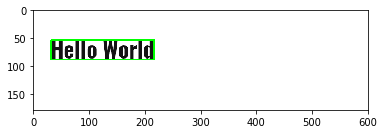

Cropped Image:


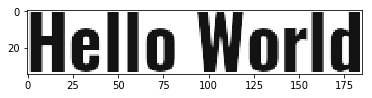

Resized Image: (224 x 224 For RESNET feature extraction)


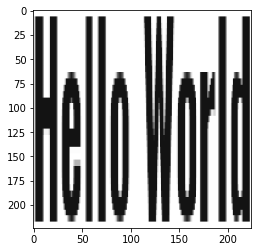

In [8]:
def test_pipeline():
    im = cv2.imread('test_image.png')
    x1, y1, x2, y2 = get_text_coordinates(im)
    
    print ("Original Image:")
    imgplot = plt.imshow(cv2.rectangle(im.copy(), (x1, y1), (x2, y2), (0,255,0), 2))
    plt.show()
    
    cropped_im = im[y1:y2, x1:x2]
    
    print ("Cropped Image:")
    imgplot = plt.imshow(cropped_im)
    plt.show()

    resized_cropped_im = cv2.resize(cropped_im, (224, 224), interpolation=cv2.INTER_AREA)
    
    print ("Resized Image: (224 x 224 For RESNET feature extraction)")
    imgplot = plt.imshow(resized_cropped_im)
    plt.show()

test_pipeline()

In [9]:
%%time

# Preprocess and save all the images generated with text and transformed

os.makedirs('data/preprocessed_data',  exist_ok=True)
file_paths_preprocessed = []

for file_path in list(df_raw['file_path']):
    im = cv2.imread(file_path)
    x1, y1, x2, y2 = get_text_coordinates(im)
        
    cropped_im = im[y1:y2, x1:x2]
    resized_cropped_im = cv2.resize(cropped_im, (224, 224), interpolation=cv2.INTER_AREA)
    
    save_filepath = 'data/preprocessed_data/{}'.format(file_path.split('/')[-1])
    file_paths_preprocessed.append(save_filepath)
    cv2.imwrite(save_filepath, resized_cropped_im)

CPU times: user 34.2 s, sys: 1.99 s, total: 36.1 s
Wall time: 34.6 s


In [10]:
df_raw['file_path_preprocessed'] = file_paths_preprocessed
df_raw.to_csv("raw_file.csv", index=False)

In [11]:
# Train and test file generated before performing any experiment (0.3 test split)

df_train, df_test = train_test_split(df_raw, stratify=list(df_raw['label']), test_size=0.3, random_state=42)
df_train.to_csv("train_file.csv", index=False)
df_test.to_csv("test_file.csv", index=False)